<a href="https://colab.research.google.com/github/AglaiaVas/Building-a-Trading-Agent-with-Reinforcement-Learning/blob/main/Final_Trading_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Deep Q-Network (DDQN) for building a Trading Agent
### Introduction

In the code, **Double Deep Q-Network (DDQN)** is used to train an agent that interacts with a trading environment. The agent selects actions (buy, sell, hold) based on market data and seeks to maximize cumulative rewards. DDQN helps reduce **overestimation bias** by using two networks: the **online network** for selecting actions and the **target network** for evaluating them.

---

### Key Concepts in the Code

1. **Q-Learning**:  
   The agent learns to maximize cumulative rewards by updating Q-values for state-action pairs. The Q-value update follows the **Bellman Equation**:

   $$
   Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)
   $$

   Where:
   - $Q(s, a)$: Q-value for action $a$ in state $s$
   - $\alpha$: Learning rate
   - $r$: Reward for action $a$
   - $\gamma$: Discount factor for future rewards
   - $s'$: The next state
   - $\max_{a'} Q(s', a')$: Maximum Q-value for the next state

2. **Double DQN**:  
   The code uses two networks to decouple action selection and evaluation:
   - **Online Network** ($Q_{\text{online}}(s, a)$): Used to select the action with the highest Q-value.
   - **Target Network** ($Q_{\text{target}}(s, a)$): Used to evaluate the value of the chosen action.

   The DDQN update rule is:

   $$
   Q_{\text{online}}(s, a) \leftarrow Q_{\text{online}}(s, a) + \alpha \left( r + \gamma Q_{\text{target}}(s', \arg\max_{a'} Q_{\text{online}}(s', a')) - Q_{\text{online}}(s, a) \right)
   $$

   This reduces overestimation by separating the action selection (via the online network) from value evaluation (via the target network).

3. **Experience Replay**:  
   The agent stores experiences $(s, a, r, s')$ in a replay buffer. During training, random mini-batches are sampled from the buffer to break correlations between consecutive experiences, improving learning stability.

4. **Epsilon-Greedy Policy**:  
   The agent balances exploration and exploitation using an **epsilon-greedy policy**. With probability $\epsilon$, a random action is chosen (exploration). With probability $1 - \epsilon$, the agent selects the action with the highest Q-value (exploitation):

   $$
   \pi(a|s) =
   \begin{cases}
   \text{random action} & \text{with probability } \epsilon \\
   \arg\max_a Q_{\text{online}}(s, a) & \text{with probability } 1 - \epsilon
   \end{cases}
   $$

   The epsilon value decays over time, gradually reducing exploration.

5. **Target Network Update**:  
   Periodically, the target network is updated by copying the weights from the online network:

   $$
   Q_{\text{target}}(s, a) \leftarrow Q_{\text{online}}(s, a)
   $$

   This keeps the target network stable, which helps prevent oscillations during training.




In [71]:
import talib

In [72]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the equivalent of G:\My Drive\Colab Notebooks\Project
os.chdir('/content/drive/My Drive/Colab Notebooks/Project')

# Verify the current working directory
print("Current Working Directory:", os.getcwd())

# Now you can access your .py files within this folder


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory: /content/drive/My Drive/Colab Notebooks/Project


In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.envs.registration import register


In [75]:
# Set NumPy random seed
np.random.seed(42)

# Set PyTorch random seed
torch.manual_seed(42)

# If you are using CUDA (GPU) as well, you should also set the seed for all GPUs
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # If you are using multi-GPU

In [76]:
sns.set_style('whitegrid')

In [77]:
if torch.cuda.is_available():
    print('Using GPU')
    # Optional: Set memory growth (PyTorch handles memory management differently,
    # but setting device or manual memory management is common).
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU


In [78]:
results_path = Path('results', 'trading_agent')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [79]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

Now we create our gym enviroment using the classes created in Trading_Environment_Add_py  

In [80]:
trading_days = 252

In [81]:
register(
    id='trading_agent-v0',
    entry_point='Trading_Environment_Add:TradingEnvironment',
    max_episode_steps=trading_days
)


Now set all the parameters of the model

In [82]:
trading_cost_bps = 1e-5
time_cost_bps = 1e-4

In [83]:
f'Trading costs: {trading_cost_bps:.4%} | Time costs: {time_cost_bps:.4%}'

'Trading costs: 0.0010% | Time costs: 0.0100%'

# Creating the Custom Trading Environment

In this part of the code, we are using `gym.make()` to create a custom trading environment called `trading_agent-v0`. This environment simulates trading on the S&P 500 (ticker: `^GSPC`). The environment is configured with the following parameters:

- **trading_days**: The number of trading days per episode.
- **trading_cost_bps**: The transaction cost per trade, expressed in basis points (bps).
- **time_cost_bps**: The holding cost per time step (e.g., overnight fees), also in basis points.

This environment setup allows reinforcement learning agents to interact with market data and make trading decisions under realistic cost conditions.

In [84]:
from gym.wrappers import StepAPICompatibility

# Wrap your environment with the compatibility wrapper
trading_environment = gym.make('trading_agent-v0',
                               ticker='^GSPC',
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps)

# Add the compatibility wrapper
trading_environment = StepAPICompatibility(trading_environment)


INFO:Trading_Environment_Add:Loading data for ^GSPC starting from October 2004...
[*********************100%***********************]  1 of 1 completed
INFO:Trading_Environment_Add:Successfully retrieved data for ^GSPC.
INFO:Trading_Environment_Add:None


Raw data saved to ^GSPC_raw_data.csv
Raw data:
                   Close      Volume          Low         High
Date                                                         
2004-10-01  1131.500000  1582200000  1114.579956  1131.640015
2004-10-04  1135.170044  1534000000  1131.500000  1140.130005
2004-10-05  1134.479980  1418400000  1132.030029  1137.869995
2004-10-06  1142.050049  1416700000  1132.939941  1142.050049
2004-10-07  1130.650024  1447500000  1130.500000  1142.050049
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5004 entries, 2004-11-17 to 2024-10-04
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   returns    5004 non-null   float64
 1   ret_2      5004 non-null   float64
 2   ret_5      5004 non-null   float64
 3   ret_10     5004 non-null   float64
 4   ret_21     5004 non-null   float64
 5   rsi        5004 non-null   float64
 6   macd       5004 non-null   float64
 7   atr        5004 non-null   f

In [85]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

# DDQNAgent Class

The `DDQNAgent` class implements a **Double Deep Q-Network (DDQN)** to train an agent using reinforcement learning. The agent interacts with a trading environment, aiming to maximize cumulative rewards by choosing actions (e.g., buy, sell, hold) based on the market state.

### Key Components:
1. **Online Network**: This neural network selects actions by estimating Q-values for each state-action pair. The network is trained to predict future rewards based on current observations.

2. **Target Network**: A separate network used for action evaluation. It is updated periodically with the weights from the online network. By decoupling action selection from evaluation, DDQN reduces the overestimation bias inherent in standard DQN.

3. **Experience Replay**: The agent stores experiences (state, action, reward, next state) in a replay buffer. During training, random samples (mini-batches) from the buffer are used to break the correlation between consecutive experiences, leading to more stable learning.

4. **Epsilon-Greedy Policy**: The agent uses an epsilon-greedy policy to balance exploration and exploitation. It chooses a random action with probability $\epsilon$ and the action with the highest Q-value with probability $1 - \epsilon$. Epsilon decays over time, reducing exploration as the agent learns.

5. **Training**: The agent is trained using mini-batch gradient descent. The loss is the difference between the predicted Q-values from the online network and the target Q-values, computed using the target network. The loss is minimized to improve the Q-value estimations over time.


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import logging

# Set up logging configuration
logging.basicConfig(level=logging.DEBUG)

class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):
        # Initialize parameters for the DDQN agent
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)  # Replay buffer
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        # Set device to GPU if available, otherwise use CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Build the online and target networks, and move them to the correct device
        self.online_network = self.build_model().to(self.device)
        self.target_network = self.build_model().to(self.device)
        self.update_target()

        # Initialize epsilon for epsilon-greedy action selection
        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        # Track metrics for episodes, steps, rewards, and training
        self.total_steps = 0
        self.episodes = 0
        self.episode_length = 0
        self.rewards_history = []
        self.steps_per_episode = []
        self.episode_reward = 0

        # Set batch size and target network update frequency (tau)
        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.train = True

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.online_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def build_model(self):
        """
        Build the neural network model based on the architecture provided.
        The model will be a sequential feed-forward network with ReLU activation.
        """
        layers = []
        input_dim = self.state_dim

        for units in self.architecture:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))  # Add dropout for regularization
            input_dim = units

        # Output layer to map to num_actions
        layers.append(nn.Linear(input_dim, self.num_actions))

        return nn.Sequential(*layers)

    def update_target(self):
        """
        Copy the weights from the online network to the target network.
        This is done periodically to stabilize training.
        """
        self.target_network.load_state_dict(self.online_network.state_dict())

    def epsilon_greedy_policy(self, state):
        """
        Select an action using epsilon-greedy policy.
        With probability epsilon, choose a random action (exploration).
        Otherwise, choose the action with the highest Q-value (exploitation).
        """
        self.total_steps += 1

        # Explore: select a random action
        if random.random() <= self.epsilon:
            return random.choice(range(self.num_actions))  # Random action (exploration)

        # Exploit: select the action with the highest Q-value
        state_tensor = torch.FloatTensor(state).to(self.device).unsqueeze(0)  # Add batch dimension

        # Get Q-values from the online network
        with torch.no_grad():  # No gradient computation during inference
            q_values = self.online_network(state_tensor).cpu().numpy()  # Get Q-values and convert to NumPy

        # Select the action with the highest Q-value
        action = np.argmax(q_values)  # Get index of the max Q-value
        return action  # Return the action as an integer

    def memorize_transition(self, s, a, r, s_prime, not_done):
        """
        Store a transition (s, a, r, s') in the replay buffer.
        If the episode ends (done), handle epsilon decay and reset episode metrics.
        """
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        """
        Train the online network using experience replay.
        Sample a random batch of transitions from the replay buffer and update the network.
        """
        if len(self.experience) < self.batch_size:
            logging.debug("Not enough experiences to sample.")
            return

        # Sample a minibatch from the replay buffer
        minibatch = random.sample(self.experience, self.batch_size)
        states, actions, rewards, next_states, not_done = zip(*minibatch)

        # Convert experience data into PyTorch tensors and move them to the correct device
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device).view(-1)  # Shape: [batch_size]
        next_states = torch.FloatTensor(next_states).to(self.device)
        not_done = torch.FloatTensor(not_done).to(self.device).view(-1)  # Shape: [batch_size]

        # Debugging statements to check shapes
        logging.debug("Shapes before target calculation:")
        logging.debug(f"rewards: {rewards.shape}, not_done: {not_done.shape}")

        # Compute Q-values for the next states using the online network
        next_q_values = self.online_network(next_states)

        # Get the best actions for the next states
        best_actions = next_q_values.argmax(dim=1)

        # Compute Q-values for the next states using the target network
        next_q_values_target = self.target_network(next_states)

        # Gather target Q-values using the actions from next states
        target_q_values = next_q_values_target.gather(1, best_actions.unsqueeze(1)).squeeze(1)  # Shape: [batch_size]

        # Debugging statement to check the shape of target_q_values
        logging.debug(f"target_q_values shape: {target_q_values.shape}")

        # Compute the target Q-value: r + gamma * max(Q(s', a'))
        targets = rewards + not_done * self.gamma * target_q_values

        # Compute Q-values for the current states using the online network
        q_values = self.online_network(states)

        # Gather the Q-values corresponding to the actions taken
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1) # Select Q-values for actions taken


        # Compute the loss (difference between predicted and target Q-values)
        loss = self.criterion(q_values, targets.detach())

        # Backpropagate the loss and
        # Backpropagate the loss and update the network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Track the loss for analysis
        self.losses.append(loss.item())

        # Periodically update the target network based on tau
        if self.total_steps % self.tau == 0:
            self.update_target()


# Set Hyperparameters
1. **Discount Factor (`gamma`)**:
   - **Value**: `0.99`
   - Controls how much the agent values future rewards compared to immediate rewards. A value close to 1 favors long-term rewards over short-term gains.

2. **Target Network Update Frequency (`tau`)**:
   - **Value**: `100`
   - Defines how often the target network is updated with the online network’s weights. This helps stabilize the learning process.

3. **Neural Network Architecture**:
   - **Value**: `(256, 256)`
   - Specifies the number of units (neurons) in each hidden layer of the network. In this case, two hidden layers with 256 units each are used to represent the Q-values.

4. **Learning Rate (`learning_rate`)**:
   - **Value**: `0.0001`
   - Determines the step size for updating the network during training. A smaller value ensures gradual learning and helps avoid large fluctuations in weight updates.

5. **L2 Regularization (`l2_reg`)**:
   - **Value**: `1e-6`
   - Helps prevent overfitting by penalizing large weights in the network, which can lead to better generalization to unseen data.

6. **Experience Replay Capacity (`replay_capacity`)**:
   - **Value**: `1e6`
   - Defines the maximum size of the replay buffer that stores past experiences (state, action, reward, next state, done). Experiences are sampled from this buffer during training.

7. **Batch Size (`batch_size`)**:
   - **Value**: `4096`
   - Specifies the number of experiences sampled from the replay buffer for each training step. A larger batch size can lead to more stable learning.

8. **Epsilon-Greedy Policy**:
   - **`epsilon_start`**: Initial exploration value (`1.0`). High exploration at the start of training.
   - **`epsilon_end`**: Final exploration value (`0.01`). Low exploration after the agent has learned from its environment.
   - **`epsilon_decay_steps`**: Number of steps over which `epsilon` decays linearly from `epsilon_start` to `epsilon_end` (250 steps).
   - **`epsilon_exponential_decay`**: An additional exponential decay factor (`0.99`) applied to epsilon to further fine-tune the balance between exploration and exploitation.

In [87]:
gamma = .99  # discount factor
tau = 100  # target network update frequency
#NN Architecture
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization
#Experience Replay
replay_capacity = int(1e6)
batch_size = 4096
#greedy Policy
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [88]:
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [89]:
total_steps = 0
max_episodes = 800
#Initialize variables
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []
#Visualization
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1,
                          win_ratio, epsilon))

In [90]:
# Train Agent
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    logging.debug(f"Initial state: {this_state}")

    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        logging.debug(f"Action taken: {action}")

        next_state, reward, done, _ = trading_environment.step(action)
        logging.debug(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

        ddqn.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()

        if done:
            break
        this_state = next_state

    # get DataFrame with sequence of actions, returns, and nav values
    result = trading_environment.env.simulator.results()

    # get results of last step
    final = result.iloc[-2]
    logging.debug(f"Final result of episode {episode}: {final}")

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent and market NAV results
    diff = nav - market_nav
    diffs.append(diff)

    if episode % 10 == 0:
        track_results(episode,
                      np.mean(navs[-100:]),
                      np.mean(navs[-10:]),
                      np.mean(market_navs[-100:]),
                      np.mean(market_navs[-10:]),
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100),
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()




  10 | 00:00:01 | Agent:  -4.0% ( -4.0%) | Market:   6.3% (  6.3%) | Wins: 20.0% | eps:  0.960
  20 | 00:00:32 | Agent:  -0.6% (  2.9%) | Market:  11.8% ( 17.3%) | Wins: 25.0% | eps:  0.921
  30 | 00:01:56 | Agent:  -0.1% (  0.8%) | Market:  12.5% ( 13.8%) | Wins: 20.0% | eps:  0.881
  40 | 00:03:21 | Agent:  -0.7% ( -2.4%) | Market:  12.5% ( 12.6%) | Wins: 20.0% | eps:  0.842
  50 | 00:04:48 | Agent:  -2.2% ( -8.1%) | Market:  11.5% (  7.8%) | Wins: 20.0% | eps:  0.802
  60 | 00:06:15 | Agent:  -0.9% (  5.7%) | Market:  12.0% ( 14.3%) | Wins: 21.7% | eps:  0.762
  70 | 00:07:44 | Agent:   0.2% (  6.7%) | Market:  11.9% ( 11.5%) | Wins: 24.3% | eps:  0.723
  80 | 00:09:17 | Agent:   0.7% (  4.3%) | Market:  12.6% ( 17.2%) | Wins: 22.5% | eps:  0.683
  90 | 00:10:51 | Agent:   0.6% ( -0.7%) | Market:  12.6% ( 13.1%) | Wins: 23.3% | eps:  0.644
 100 | 00:12:26 | Agent:   0.3% ( -2.0%) | Market:  12.0% (  6.2%) | Wins: 22.0% | eps:  0.604
 110 | 00:14:02 | Agent:   1.2% (  4.8%) | Market:

In [105]:
# Ensure that all lists are the same length as the episode count
min_length = min(len(navs), len(market_navs), len(diffs), episode)

# Truncate lists to match the smallest length if necessary
navs = navs[:min_length]
market_navs = market_navs[:min_length]
diffs = diffs[:min_length]

# Construct the DataFrame
final_results = pd.DataFrame({
    'Episode': list(range(1, min_length + 1)),
    'Agent': navs,
    'Market': market_navs,
    'Difference': diffs
}).set_index('Episode')

In [108]:
# Calculate the rolling mean over the last 100 episodes for both Agent and Market NAVs, subtracting 1 and showing as percentage
final_results['Agent_rolling_mean'] = (final_results['Agent'].rolling(window=100).mean() - 1) * 100
final_results['Market_rolling_mean'] = (final_results['Market'].rolling(window=100).mean() - 1) * 100

# Compute the rolling win ratio over the last 100 points, where the agent outperformed the market
final_results['Wins_rolling_mean'] = (final_results['Difference'] > 0).rolling(window=100).mean()

In [109]:
final_results.to_csv(results_path / 'final_results.csv', index=False)

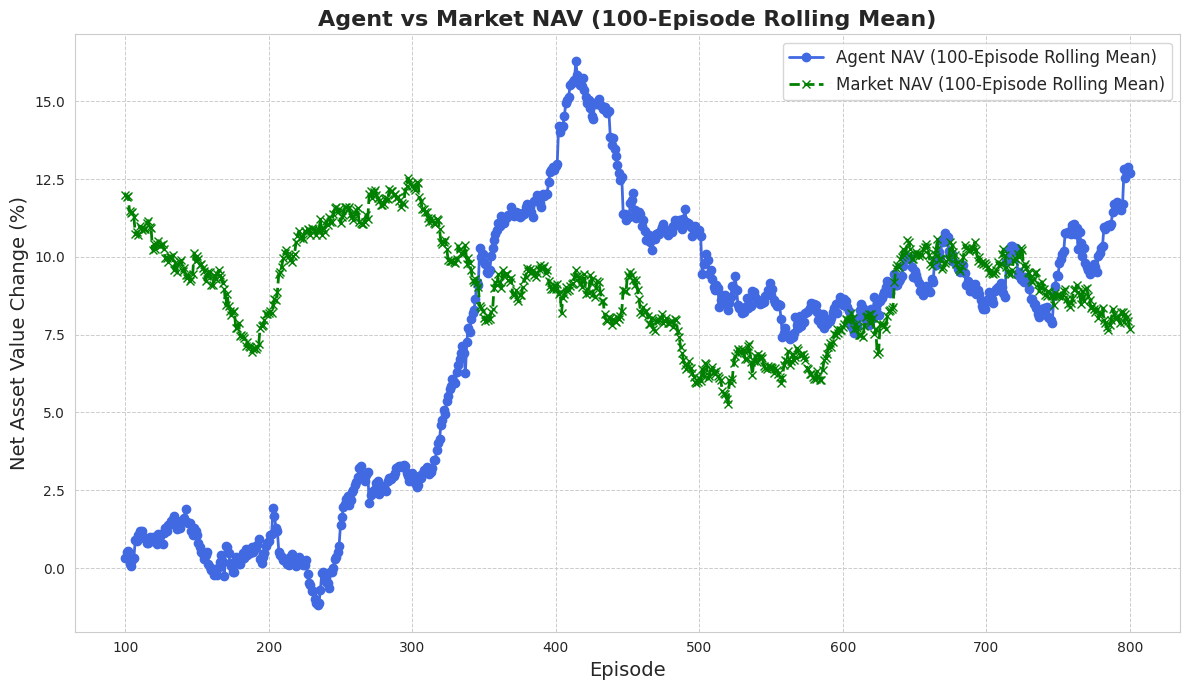

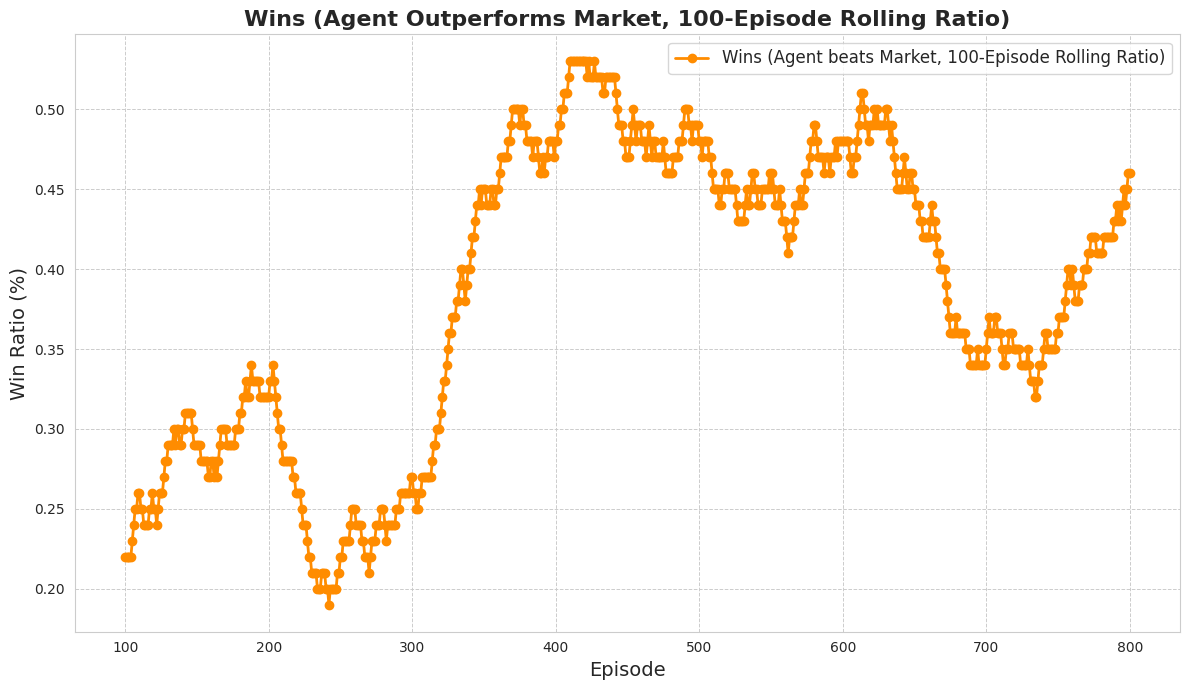

In [110]:
# First Plot: Agent vs Market NAV (100-Episode Rolling Mean)
plt.figure(figsize=(12, 7))

# Plot Agent's rolling mean performance
plt.plot(final_results['Agent_rolling_mean'], label='Agent NAV (100-Episode Rolling Mean)', color='royalblue',
         linestyle='-', marker='o', markersize=6, linewidth=2)

# Plot Market's rolling mean performance
plt.plot(final_results['Market_rolling_mean'], label='Market NAV (100-Episode Rolling Mean)', color='green',
         linestyle='--', marker='x', markersize=6, linewidth=2)

# Adding labels and title with larger fonts
plt.title('Agent vs Market NAV (100-Episode Rolling Mean)', fontsize=16, fontweight='bold')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Net Asset Value Change (%)', fontsize=14)

# Adding legend with larger font size
plt.legend(fontsize=12)

# Show grid with minor lines for more precision
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Display the first plot
plt.tight_layout()
plt.show()

# Second Plot: Wins (100-Episode Rolling Win Ratio)
plt.figure(figsize=(12, 7))

# Plot the Wins (rolling win ratio where Agent beats Market)
plt.plot(final_results['Wins_rolling_mean'], label='Wins (Agent beats Market, 100-Episode Rolling Ratio)',
         color='darkorange', linestyle='-', marker='o', markersize=6, linewidth=2)

# Adding labels and title with larger fonts
plt.title('Wins (Agent Outperforms Market, 100-Episode Rolling Ratio)', fontsize=16, fontweight='bold')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Win Ratio (%)', fontsize=14)

# Adding legend with larger font size
plt.legend(fontsize=12)

# Show grid with minor lines for more precision
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Display the second plot
plt.tight_layout()
plt.show()


1. **Agent vs Market NAV**:
   - The rolling mean of the agent's NAV compared to the market NAV gives insight into the agent's overall performance. The agent often tracks the market closely, with occasional periods of outperformance and underperformance. This highlights the agent's ability to follow market movements while attempting to capitalize on short-term opportunities.
   - The S&P 500 tends to grow by approximately 10% annually, which presents a challenge for the agent to consistently outperform such a strong and diverse index over time.

2. **Wins (Rolling Win Ratio)**:
   - The rolling win ratio shows how often the agent outperforms the market over a 100-episode window. While the agent successfully outperforms in certain windows, it struggles to maintain consistency over all episodes.
   - The S&P 500 index is composed of top-performing stocks, giving the market a natural advantage in bullish conditions, making it harder for the agent to outperform, especially during sustained growth phases.

   - The S&P 500 is a diversified index, and its inherent stability makes it challenging for a trading agent to outperform without taking significant risks. The agent is competing against a benchmark that benefits from overall market growth and stability.
   - During strong bull markets, the agent is at a disadvantage, as the index tends to follow steady upward trends. This limits the agent’s ability to find short-term opportunities.

   - The agent's ability to adapt to market fluctuations and take advantage of short-term deviations is a positive indicator of its potential. The use of technical indicators like RSI, MACD, and ATR aids in identifying market reversals or entry/exit points.
   - Reinforcement learning allows the agent to learn from experience and optimize its strategy over time, which is valuable in dynamic or volatile market conditions where passive strategies may underperform.


### Additional Considerations:
- **More Episodes for Better Results**:
   - Running additional episodes would enhance the agent's ability to learn and refine its strategy, improving overall performance. However, this comes at the expense of longer computational time. Reinforcement learning models typically require extensive iterations to converge on optimal strategies, which presents a trade-off between model accuracy and resource use. For example, the current run took 3 hours, and increasing the number of episodes would proportionally extend this time.

### Conclusion:
The DDQN-based trading agent demonstrates potential in outperforming the S&P 500 in specific market conditions, particularly during volatile or corrective phases. However, it faces significant challenges in consistently outperforming a diversified and upward-trending index like the S&P 500. Despite these challenges, the agent’s ability to learn and adapt over time highlights the power of reinforcement learning in trading applications. Further improvements to the model, including more episodes, additional data inputs, and optimization techniques, could enhance the agent’s overall performance and make it more competitive in varied market conditions.


In [70]:
#Only uncomment the below if you need to install the Talib library


#url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
#!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
#url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
#!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
#import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4059    0  4059    0     0  12978      0 --:--:-- --:--:-- --:--:-- 13009
100  517k  100  517k    0     0   830k      0 --:--:-- --:--:-- --:--:-- 4535k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4063    0  4063    0     0   9052      0 --:--:-- --:--:-- --:--:--  9069
100  392k  100  392k    0     0   510k      0 --:--:-- --:--:-- --:--:-- 86.1M
